In [61]:
import pandas as pd
import torch
from torch import nn
import numpy as np

In [2]:
# Make dataset

from torch.utils.data import Dataset, DataLoader

class dummy_dataset(Dataset):

    def __init__(self, x, y, x_min = None, y_min = None, x_max = None, y_max = None ): 
        if (x_min is None):
            self.y_min = torch.min(y, dim=0)[0] # add min and max
            self.x_min = torch.min(x, dim=0)[0]
            self.y_max = torch.max(y, dim=0)[0]
            self.x_max = torch.max(x, dim=0)[0]
        else:
            self.y_min = y_min
            self.x_min = x_min
            self.y_max = y_max
            self.x_max = x_max
        self.features = self.custom_norm_function(x, self.x_min, self.x_max)
        self.labels = self.custom_norm_function(y, self.y_min, self.y_max)
    
    def __len__(self): 
        return len(self.features)

    def __getitem__(self, idx): 
        return self.features[idx], self.labels[idx]
    
    def custom_norm_function(self, x, min_vec, max_vec):   #normalization
        x = (x-min_vec)/(max_vec-min_vec)
        return x

In [3]:
x = torch.load('x.pt')
y = torch.load('y.pt')

In [31]:
import sklearn
from sklearn.model_selection import train_test_split

x_train_0, x_test, y_train_0, y_test = train_test_split(x, y, test_size = 0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train_0, y_train_0,  train_size = 0.8)

#x_train.requires_grad_(True)
#x_test.requires_grad_(True)
#x_val.requires_grad_(True)

train_dataset = dummy_dataset(x_train, y_train)
test_dataset = dummy_dataset(x_test, y_test)
val_dataset = dummy_dataset(x_val, y_val)

trainLoader = DataLoader(train_dataset, batch_size=8, shuffle=True)
testLoader = DataLoader(test_dataset, batch_size=16, shuffle=False)
valLoader =  DataLoader(val_dataset, batch_size=8, shuffle=False)

x_min_train =  train_dataset.x_min 
x_max_train =  train_dataset.x_max

y_min_train =  train_dataset.y_min
y_max_train =  train_dataset.y_max   

In [32]:
class NN(nn.Module): 
    def __init__(self): 
        super(NN, self).__init__()
        self.dense = nn.Linear(550, 32)
        self.out = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.sigmoid(self.dense(x))
        return self.out(x)

In [52]:
# Функция для вычисления R-релевантности
def feature_relevance(model, data_loader):
    model.eval()
    feature_importances = np.zeros(550)
    with torch.enable_grad():
        for data, _ in data_loader:
            x = data.float()
            x = x.requires_grad_(True) 
            # Прямой проход через слой dense
            dense_out = torch.sigmoid(model.dense(x))
            # Вычисление градиента между слоями
            dense_out = dense_out.mean(0)
            dense_out.backward(torch.ones_like(dense_out), retain_graph=True)
            
            # Вычисление подразумеваемой важности (умножение градиента на входной тензор)
            imp = (x * x.grad).abs()
            feature_importances += imp.sum(dim=0).detach().numpy()
            x.grad.zero_()
    return feature_importances

In [53]:
model = NN()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [69]:
# Обучение модели
num_epochs = 2000
for epoch in range(num_epochs):
    model.train()
    for i, (x_batch, y_batch) in enumerate(trainLoader):
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.float(), y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.enable_grad():
        for x_batch, y_batch in valLoader:
            y_pred = model(x_batch.float())
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(valLoader)}")

R_relevance = feature_relevance(model, trainLoader)
print(R_relevance)

Epoch 1/2000, Validation Loss: 0.026826872470168493
Epoch 2/2000, Validation Loss: 0.026302438684372653
Epoch 3/2000, Validation Loss: 0.028768403159385007
Epoch 4/2000, Validation Loss: 0.02657245152957174
Epoch 5/2000, Validation Loss: 0.02726329075012371
Epoch 6/2000, Validation Loss: 0.025146965831000456
Epoch 7/2000, Validation Loss: 0.023926330505754163
Epoch 8/2000, Validation Loss: 0.02460731400288987
Epoch 9/2000, Validation Loss: 0.026610981953877743
Epoch 10/2000, Validation Loss: 0.027187229396869215
Epoch 11/2000, Validation Loss: 0.023497478542051715
Epoch 12/2000, Validation Loss: 0.023558914179888927
Epoch 13/2000, Validation Loss: 0.02445192667120728
Epoch 14/2000, Validation Loss: 0.02342033988074803
Epoch 15/2000, Validation Loss: 0.022720026663596245
Epoch 16/2000, Validation Loss: 0.02373323691895193
Epoch 17/2000, Validation Loss: 0.025044647066597262
Epoch 18/2000, Validation Loss: 0.022487287561824238
Epoch 19/2000, Validation Loss: 0.022925445297968982
Epoch 20

Epoch 156/2000, Validation Loss: 0.018647711750340495
Epoch 157/2000, Validation Loss: 0.01778668399950071
Epoch 158/2000, Validation Loss: 0.01767699513636282
Epoch 159/2000, Validation Loss: 0.01759863469883488
Epoch 160/2000, Validation Loss: 0.017251904303964668
Epoch 161/2000, Validation Loss: 0.020105580019995142
Epoch 162/2000, Validation Loss: 0.017480884363997813
Epoch 163/2000, Validation Loss: 0.01923119604913428
Epoch 164/2000, Validation Loss: 0.01669159233610103
Epoch 165/2000, Validation Loss: 0.019023728917082077
Epoch 166/2000, Validation Loss: 0.01777883774141311
Epoch 167/2000, Validation Loss: 0.016817813760770448
Epoch 168/2000, Validation Loss: 0.017491300881756107
Epoch 169/2000, Validation Loss: 0.01767769063621562
Epoch 170/2000, Validation Loss: 0.017392850697589356
Epoch 171/2000, Validation Loss: 0.017234765400995947
Epoch 172/2000, Validation Loss: 0.017324675104539947
Epoch 173/2000, Validation Loss: 0.017747509046451254
Epoch 174/2000, Validation Loss: 0.

Epoch 309/2000, Validation Loss: 0.01670405792039264
Epoch 310/2000, Validation Loss: 0.017616617683567298
Epoch 311/2000, Validation Loss: 0.016485728457707745
Epoch 312/2000, Validation Loss: 0.01602068127800025
Epoch 313/2000, Validation Loss: 0.017993737998264207
Epoch 314/2000, Validation Loss: 0.01658225284660454
Epoch 315/2000, Validation Loss: 0.015173961668023981
Epoch 316/2000, Validation Loss: 0.01564058847914322
Epoch 317/2000, Validation Loss: 0.015943239090268988
Epoch 318/2000, Validation Loss: 0.016191848845268985
Epoch 319/2000, Validation Loss: 0.01765142617082371
Epoch 320/2000, Validation Loss: 0.016120969726625193
Epoch 321/2000, Validation Loss: 0.01746555101427962
Epoch 322/2000, Validation Loss: 0.015574342392100354
Epoch 323/2000, Validation Loss: 0.016578495090254972
Epoch 324/2000, Validation Loss: 0.015142009049744132
Epoch 325/2000, Validation Loss: 0.015922946235455246
Epoch 326/2000, Validation Loss: 0.017865762639775917
Epoch 327/2000, Validation Loss: 0

Epoch 462/2000, Validation Loss: 0.01696770687147274
Epoch 463/2000, Validation Loss: 0.015270227727203097
Epoch 464/2000, Validation Loss: 0.01566133738132983
Epoch 465/2000, Validation Loss: 0.016214307143834997
Epoch 466/2000, Validation Loss: 0.014473632591829981
Epoch 467/2000, Validation Loss: 0.015251284094582417
Epoch 468/2000, Validation Loss: 0.017744343008710167
Epoch 469/2000, Validation Loss: 0.015380984644700847
Epoch 470/2000, Validation Loss: 0.014965634221409398
Epoch 471/2000, Validation Loss: 0.014432448822449458
Epoch 472/2000, Validation Loss: 0.015251898805265087
Epoch 473/2000, Validation Loss: 0.015567475335279642
Epoch 474/2000, Validation Loss: 0.015960524746680273
Epoch 475/2000, Validation Loss: 0.01640275587196192
Epoch 476/2000, Validation Loss: 0.016104597207593482
Epoch 477/2000, Validation Loss: 0.015509608079351875
Epoch 478/2000, Validation Loss: 0.014807547294314351
Epoch 479/2000, Validation Loss: 0.01631069098069224
Epoch 480/2000, Validation Loss:

Epoch 615/2000, Validation Loss: 0.015269322588599022
Epoch 616/2000, Validation Loss: 0.014838289575113805
Epoch 617/2000, Validation Loss: 0.014708379695439007
Epoch 618/2000, Validation Loss: 0.014097990708633856
Epoch 619/2000, Validation Loss: 0.014988180416680229
Epoch 620/2000, Validation Loss: 0.015392505305179747
Epoch 621/2000, Validation Loss: 0.01685618492472869
Epoch 622/2000, Validation Loss: 0.015908178694046496
Epoch 623/2000, Validation Loss: 0.017007504755998874
Epoch 624/2000, Validation Loss: 0.01537997221749044
Epoch 625/2000, Validation Loss: 0.015883449497280468
Epoch 626/2000, Validation Loss: 0.016122321706588883
Epoch 627/2000, Validation Loss: 0.014840141391413484
Epoch 628/2000, Validation Loss: 0.016282959161393388
Epoch 629/2000, Validation Loss: 0.015505221671756796
Epoch 630/2000, Validation Loss: 0.015587934878985186
Epoch 631/2000, Validation Loss: 0.014765910399425763
Epoch 632/2000, Validation Loss: 0.014688642992326495
Epoch 633/2000, Validation Los

Epoch 768/2000, Validation Loss: 0.014215979329745552
Epoch 769/2000, Validation Loss: 0.0162731475115654
Epoch 770/2000, Validation Loss: 0.017014179763198276
Epoch 771/2000, Validation Loss: 0.014100401552154971
Epoch 772/2000, Validation Loss: 0.014334688441429842
Epoch 773/2000, Validation Loss: 0.014239982011187504
Epoch 774/2000, Validation Loss: 0.015039246360599582
Epoch 775/2000, Validation Loss: 0.014894370652660678
Epoch 776/2000, Validation Loss: 0.015958622888231303
Epoch 777/2000, Validation Loss: 0.01548254799405222
Epoch 778/2000, Validation Loss: 0.014455345483890684
Epoch 779/2000, Validation Loss: 0.014932637841857582
Epoch 780/2000, Validation Loss: 0.015840429873882643
Epoch 781/2000, Validation Loss: 0.016345945455537924
Epoch 782/2000, Validation Loss: 0.016209566244708894
Epoch 783/2000, Validation Loss: 0.014178752389083416
Epoch 784/2000, Validation Loss: 0.01486255233887662
Epoch 785/2000, Validation Loss: 0.014407806275885365
Epoch 786/2000, Validation Loss:

Epoch 921/2000, Validation Loss: 0.014768158226098798
Epoch 922/2000, Validation Loss: 0.014497320227632884
Epoch 923/2000, Validation Loss: 0.014778501891046193
Epoch 924/2000, Validation Loss: 0.016088833234528803
Epoch 925/2000, Validation Loss: 0.014107546898112824
Epoch 926/2000, Validation Loss: 0.015399676535764004
Epoch 927/2000, Validation Loss: 0.01436197032624551
Epoch 928/2000, Validation Loss: 0.014829289150602776
Epoch 929/2000, Validation Loss: 0.01780547875880206
Epoch 930/2000, Validation Loss: 0.015140097123536972
Epoch 931/2000, Validation Loss: 0.015499194865415282
Epoch 932/2000, Validation Loss: 0.015105980175986121
Epoch 933/2000, Validation Loss: 0.013992577182153855
Epoch 934/2000, Validation Loss: 0.015782727723571272
Epoch 935/2000, Validation Loss: 0.01473203192292974
Epoch 936/2000, Validation Loss: 0.01553205181592486
Epoch 937/2000, Validation Loss: 0.01843824717890226
Epoch 938/2000, Validation Loss: 0.01533308051870571
Epoch 939/2000, Validation Loss: 0

Epoch 1073/2000, Validation Loss: 0.01468826808971943
Epoch 1074/2000, Validation Loss: 0.015295684136957671
Epoch 1075/2000, Validation Loss: 0.019005096038211863
Epoch 1076/2000, Validation Loss: 0.015494617594494832
Epoch 1077/2000, Validation Loss: 0.0141640956414799
Epoch 1078/2000, Validation Loss: 0.014810805792400909
Epoch 1079/2000, Validation Loss: 0.01619293944961918
Epoch 1080/2000, Validation Loss: 0.014485375158990968
Epoch 1081/2000, Validation Loss: 0.01571016294225555
Epoch 1082/2000, Validation Loss: 0.01576680664807332
Epoch 1083/2000, Validation Loss: 0.014525426568007796
Epoch 1084/2000, Validation Loss: 0.01633773030798184
Epoch 1085/2000, Validation Loss: 0.013848141817732917
Epoch 1086/2000, Validation Loss: 0.014959026648084375
Epoch 1087/2000, Validation Loss: 0.014990722953162821
Epoch 1088/2000, Validation Loss: 0.015125419212916236
Epoch 1089/2000, Validation Loss: 0.015617429435543355
Epoch 1090/2000, Validation Loss: 0.01511953448031924
Epoch 1091/2000, V

Epoch 1223/2000, Validation Loss: 0.014639601893284377
Epoch 1224/2000, Validation Loss: 0.014778244440345168
Epoch 1225/2000, Validation Loss: 0.01523133491857632
Epoch 1226/2000, Validation Loss: 0.016962761872413086
Epoch 1227/2000, Validation Loss: 0.014604894130332223
Epoch 1228/2000, Validation Loss: 0.01694153474205857
Epoch 1229/2000, Validation Loss: 0.015044482085447047
Epoch 1230/2000, Validation Loss: 0.014666950520260005
Epoch 1231/2000, Validation Loss: 0.01613727180336362
Epoch 1232/2000, Validation Loss: 0.0150896826775236
Epoch 1233/2000, Validation Loss: 0.015069336502895523
Epoch 1234/2000, Validation Loss: 0.01549261661053991
Epoch 1235/2000, Validation Loss: 0.014925206976811673
Epoch 1236/2000, Validation Loss: 0.015143588867672605
Epoch 1237/2000, Validation Loss: 0.01451978957014695
Epoch 1238/2000, Validation Loss: 0.017168573359386333
Epoch 1239/2000, Validation Loss: 0.01598646595525149
Epoch 1240/2000, Validation Loss: 0.01564539482086479
Epoch 1241/2000, Va

Epoch 1373/2000, Validation Loss: 0.01546879658126296
Epoch 1374/2000, Validation Loss: 0.014689948354649644
Epoch 1375/2000, Validation Loss: 0.015108184013439835
Epoch 1376/2000, Validation Loss: 0.01443508118695289
Epoch 1377/2000, Validation Loss: 0.015720620018968564
Epoch 1378/2000, Validation Loss: 0.013971503371811335
Epoch 1379/2000, Validation Loss: 0.014181534223646874
Epoch 1380/2000, Validation Loss: 0.014289284006329244
Epoch 1381/2000, Validation Loss: 0.01426335204088082
Epoch 1382/2000, Validation Loss: 0.0151279572168261
Epoch 1383/2000, Validation Loss: 0.016939131237976343
Epoch 1384/2000, Validation Loss: 0.015463922709179918
Epoch 1385/2000, Validation Loss: 0.014499779144232937
Epoch 1386/2000, Validation Loss: 0.014435372420322518
Epoch 1387/2000, Validation Loss: 0.016795729179029082
Epoch 1388/2000, Validation Loss: 0.014136860641990724
Epoch 1389/2000, Validation Loss: 0.01472252742355169
Epoch 1390/2000, Validation Loss: 0.013783011316784409
Epoch 1391/2000,

Epoch 1523/2000, Validation Loss: 0.016364691109902182
Epoch 1524/2000, Validation Loss: 0.014910223138167563
Epoch 1525/2000, Validation Loss: 0.014623880790147899
Epoch 1526/2000, Validation Loss: 0.01616036730096759
Epoch 1527/2000, Validation Loss: 0.013722860303190818
Epoch 1528/2000, Validation Loss: 0.015368954142065478
Epoch 1529/2000, Validation Loss: 0.015509148574280382
Epoch 1530/2000, Validation Loss: 0.01461157002289496
Epoch 1531/2000, Validation Loss: 0.014216602977196074
Epoch 1532/2000, Validation Loss: 0.014133668217800674
Epoch 1533/2000, Validation Loss: 0.015362372795722746
Epoch 1534/2000, Validation Loss: 0.014308089763767623
Epoch 1535/2000, Validation Loss: 0.014964224539088992
Epoch 1536/2000, Validation Loss: 0.014515285835499997
Epoch 1537/2000, Validation Loss: 0.015083053006433296
Epoch 1538/2000, Validation Loss: 0.013745336868360632
Epoch 1539/2000, Validation Loss: 0.015397031258440547
Epoch 1540/2000, Validation Loss: 0.01439539823281036
Epoch 1541/20

Epoch 1673/2000, Validation Loss: 0.016097388622424245
Epoch 1674/2000, Validation Loss: 0.014775270025062374
Epoch 1675/2000, Validation Loss: 0.015481227011847442
Epoch 1676/2000, Validation Loss: 0.014341295404623713
Epoch 1677/2000, Validation Loss: 0.016657308734787688
Epoch 1678/2000, Validation Loss: 0.014652134824152303
Epoch 1679/2000, Validation Loss: 0.014061006242388905
Epoch 1680/2000, Validation Loss: 0.016389484777458743
Epoch 1681/2000, Validation Loss: 0.01429150989485146
Epoch 1682/2000, Validation Loss: 0.01414897741796627
Epoch 1683/2000, Validation Loss: 0.016311343137027104
Epoch 1684/2000, Validation Loss: 0.016172077965111345
Epoch 1685/2000, Validation Loss: 0.0159290341976887
Epoch 1686/2000, Validation Loss: 0.01630852177155468
Epoch 1687/2000, Validation Loss: 0.014933398939100912
Epoch 1688/2000, Validation Loss: 0.014487295201704954
Epoch 1689/2000, Validation Loss: 0.015835117503515562
Epoch 1690/2000, Validation Loss: 0.014413434006320324
Epoch 1691/2000

Epoch 1823/2000, Validation Loss: 0.015451592352660172
Epoch 1824/2000, Validation Loss: 0.014259910439604909
Epoch 1825/2000, Validation Loss: 0.01500785562589956
Epoch 1826/2000, Validation Loss: 0.014206479975878828
Epoch 1827/2000, Validation Loss: 0.015564351260552027
Epoch 1828/2000, Validation Loss: 0.01460549620284154
Epoch 1829/2000, Validation Loss: 0.01467894845033736
Epoch 1830/2000, Validation Loss: 0.014865511350225371
Epoch 1831/2000, Validation Loss: 0.015253180795380688
Epoch 1832/2000, Validation Loss: 0.01584060898184202
Epoch 1833/2000, Validation Loss: 0.013424137740312371
Epoch 1834/2000, Validation Loss: 0.014546187918579328
Epoch 1835/2000, Validation Loss: 0.014141947690537515
Epoch 1836/2000, Validation Loss: 0.014675689846166374
Epoch 1837/2000, Validation Loss: 0.01494016585606635
Epoch 1838/2000, Validation Loss: 0.014959300594724197
Epoch 1839/2000, Validation Loss: 0.013840730070298147
Epoch 1840/2000, Validation Loss: 0.014201281884346278
Epoch 1841/2000

Epoch 1973/2000, Validation Loss: 0.014281373093171991
Epoch 1974/2000, Validation Loss: 0.016181570868702293
Epoch 1975/2000, Validation Loss: 0.01411264790211995
Epoch 1976/2000, Validation Loss: 0.014263014196872538
Epoch 1977/2000, Validation Loss: 0.015910044604105604
Epoch 1978/2000, Validation Loss: 0.014188086392797887
Epoch 1979/2000, Validation Loss: 0.01678875972940378
Epoch 1980/2000, Validation Loss: 0.017091221654124855
Epoch 1981/2000, Validation Loss: 0.013879170751378922
Epoch 1982/2000, Validation Loss: 0.013642176338831514
Epoch 1983/2000, Validation Loss: 0.015033071786470077
Epoch 1984/2000, Validation Loss: 0.01403126866373524
Epoch 1985/2000, Validation Loss: 0.017994635067306353
Epoch 1986/2000, Validation Loss: 0.01403809551791503
Epoch 1987/2000, Validation Loss: 0.015037039206441305
Epoch 1988/2000, Validation Loss: 0.016414860196710804
Epoch 1989/2000, Validation Loss: 0.015860914559043073
Epoch 1990/2000, Validation Loss: 0.01447922782672627
Epoch 1991/2000

               R
0    1099.209007
1    1046.598431
2     979.788309
3     882.853210
4     937.682859
..           ...
545   958.720803
546  1111.132951
547  1180.319082
548  1235.544629
549  1332.246152

[550 rows x 1 columns]


Text(0, 0.5, 'R_relevance')

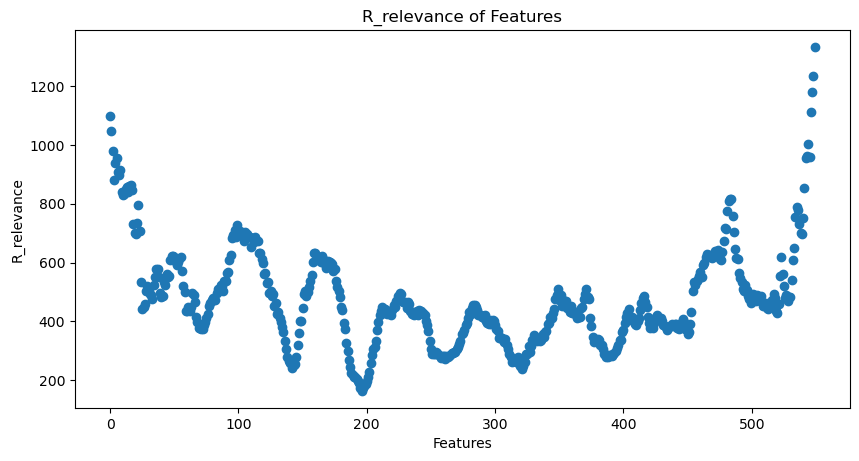

In [71]:
my_dataframe_R = pd.DataFrame(R_relevance, columns=['R'])

print(my_dataframe_R)

import matplotlib.pyplot as plt

# Строим scatterplot
plt.scatter(my_dataframe_R.index, my_dataframe_R['R'])

# Добавляем заголовок и подписи осей
plt.title('R_relevance of Features')
plt.xlabel('Features')
plt.ylabel('R_relevance')

In [72]:
my_dataframe_R.to_csv("my_dataframe_R.csv", index=False)

In [ ]:
my_dataframe_R

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Предполагая, что у вас есть DataFrame R_norm с колонкой 'R' и индексом

# Преобразуйте ваш DataFrame с индексом в колонку 'feature'
R_norm.reset_index(inplace=True)

# Превратите DataFrame в сводную таблицу, где индекс - номера признаков, столбцы - номера экспериментов
pivot_table = R_norm.pivot_table(values='R', index=R_norm.index.name, columns=R_norm.columns[1], aggfunc=np.mean)

# Визуализация тепловой диаграммы
plt.figure(figsize=(12,6))
sns.heatmap(pivot_table, cmap='viridis', annot=True)
plt.xlabel('Признаки')
plt.ylabel('Эксперименты')
plt.title('Тепловая диаграмма релевантности признаков (Deep Taylor Decomposition)')
plt.show()


NameError: name 'R_norm' is not defined